In [1]:
#https://www.kaggle.com/datatattle/covid-19-nlp-text-classification/activity
import pandas as pd
import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.cluster import KMeansClusterer, euclidean_distance
from gensim import corpora, models, utils
import nltk
nltk.download('stopwords')
# from cleantext import clean
from sklearn.feature_extraction.text import TfidfVectorizer
import string 
import re
nltk.download('wordnet')
import numpy as np
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import re 
import nltk 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold


from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()

# Feature Engineering
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

# Classification Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Performance Measures
from sklearn.metrics import accuracy_score

# Global Variables
rnd_state = 42
skfold = StratifiedKFold(n_splits=5)
from tpot import TPOTClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to /home/aakib/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aakib/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/aakib/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/aakib/sentiment/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
train = pd.read_csv('/home/aakib/Downloads/archive/Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv("/home/aakib/Downloads/archive/Corona_NLP_test.csv",encoding='latin1')

In [3]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


<h4>Step 1 - To clean the Text data

In [4]:
train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

In [5]:
def classes_def(x):
    if x ==  "Extremely Positive":
        return "2"
    elif x == "Extremely Negative":
        return "0"
    elif x == "Negative":
        return "0"
    elif x ==  "Positive":
        return "2"
    else:
        return "1"
    

train['label']=train['Sentiment'].apply(lambda x:classes_def(x))
test['label']=test['Sentiment'].apply(lambda x:classes_def(x))

In [6]:
train.label.value_counts(normalize= True)

2    0.438467
0    0.374128
1    0.187404
Name: label, dtype: float64

In [7]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
train['text_new']=train['text'].apply(lambda x:remove_urls(x))
test['text_new']=test['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
train['text']=train['text_new'].apply(lambda x:remove_html(x))
test['text']=test['text_new'].apply(lambda x:remove_html(x))


In [8]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
train['text_new']=train['text'].apply(lambda x:lower(x))
test['text_new']=test['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
train['text']=train['text_new'].apply(lambda x:remove_num(x))
test['text']=test['text_new'].apply(lambda x:remove_num(x))

In [9]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
train['text_new']=train['text'].apply(lambda x:punct_remove(x))
test['text_new']=test['text'].apply(lambda x:punct_remove(x))


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train['text']=train['text_new'].apply(lambda x:remove_stopwords(x))
test['text']=test['text_new'].apply(lambda x:remove_stopwords(x))

In [10]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
train['text_new']=train['text'].apply(lambda x:remove_mention(x))
test['text_new']=test['text'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
train['text']=train['text_new'].apply(lambda x:remove_hash(x))
test['text']=test['text_new'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
train['text_new']=train['text'].apply(lambda x:remove_space(x))
test['text_new']=test['text'].apply(lambda x:remove_space(x))
test = test.drop(columns=['text_new'])
train = train.drop(columns=['text_new'])

In [11]:
X = train["text"]
y = train["label"]

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

# We transform each text into a vector
X_features = tfidf.fit_transform(X)
y_labels = y
print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(X_features.shape))

Each of the 41157 tweets is represented by 22725 features (TF-IDF score of unigrams and bigrams)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,test_size=0.30,random_state = 0)

<h4> Applying random forest

In [14]:
rf = RandomForestClassifier()

In [15]:
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

In [16]:
rsearch = RandomizedSearchCV(rf, param_distributions = hyperF, n_iter=3, scoring='f1_weighted', n_jobs=-1, refit=True, cv=5, verbose=0, random_state=None, return_train_score=False)
rsearch.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 15, 25, 30],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 300, 500, 800,
                                                         1200]},
                   scoring='f1_weighted')

In [17]:
rsearch.best_params_

{'n_estimators': 100,
 'min_samples_split': 100,
 'min_samples_leaf': 5,
 'max_depth': 8}

In [18]:
clf = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=25, min_samples_split=15, min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
clf.fit(X_features,y_labels)

RandomForestClassifier(max_depth=25, min_samples_leaf=2, min_samples_split=15,
                       n_estimators=300, n_jobs=-1)

In [19]:
y_pred = clf.predict(X_test)

In [20]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred,average='weighted')

0.5460265559552595

/home/aakib/sentiment/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


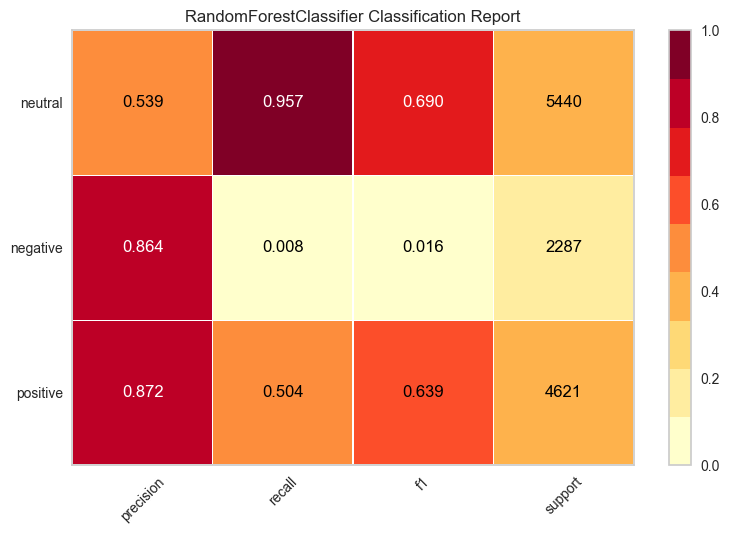

<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

In [21]:
classes = ['positive','negative','neutral']
visualizer = ClassificationReport(clf, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

/home/aakib/sentiment/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


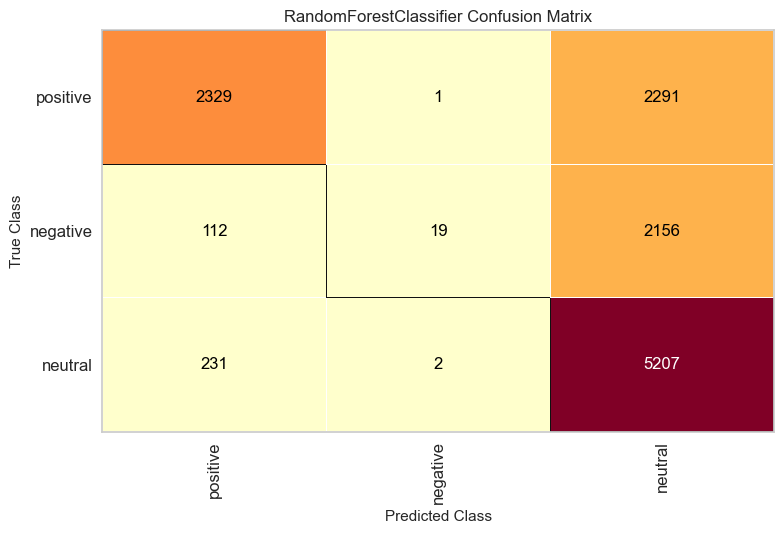

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [22]:
from yellowbrick.classifier import ConfusionMatrix
cm = ConfusionMatrix(clf, classes=['positive','negative','neutral'])
cm.fit(X_train, y_train)        # Fit the visualizer and the model
cm.score(X_test, y_test)        # Evaluate the model on the test data
cm.show()  

<h4> Applying multinomialNB

In [23]:
mnb = MultinomialNB()
hyp = dict(alpha = [1e-1, 1e-2,1e-3,1e-4,1e-5,1,10,100,1000])
search = RandomizedSearchCV(mnb, param_distributions = hyp, n_iter=5, scoring='f1_weighted', n_jobs=-1, refit=True, cv=5, verbose=0, random_state=None, return_train_score=False)
search.fit(X_train,y_train)
search.best_params_

{'alpha': 0.1}

In [24]:
mnb1 = MultinomialNB(alpha = 0.1)
mnb1.fit(X_train,y_train)
y_pred1 = mnb1.predict(X_test)

/home/aakib/sentiment/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


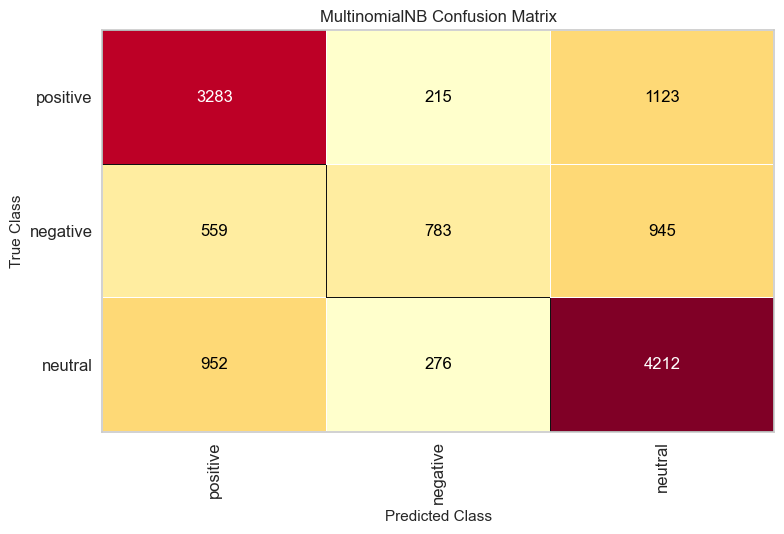

<AxesSubplot:title={'center':'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [25]:
cm1 = ConfusionMatrix(mnb1, classes=['positive','negative','neutral'])
cm1.fit(X_train, y_train)        # Fit the visualizer and the model
cm1.score(X_test, y_test)        # Evaluate the model on the test data
cm1.show()  

In [26]:
f1_score(y_test, y_pred1,average='weighted')

0.6590971538886964

As we can see multinomialNB gives better classification then random forest from confusion matrix.

<h4> Applying decision tree classifier

In [27]:
dct = DecisionTreeClassifier()
param_dist = {"max_depth": [3,5,7,9,11],"max_features": randint(1, 9),"min_samples_leaf": randint(1, 9),"criterion": ["gini", "entropy"]}
rmd = RandomizedSearchCV(dct, param_distributions = param_dist, n_iter=3, scoring='f1_weighted', n_jobs=-1, refit=True, cv=5, verbose=0, random_state=None, return_train_score=False)
rmd.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 9, 11],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8c053fa100>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8c0384bdf0>},
                   scoring='f1_weighted')

In [28]:
rmd.best_params_

{'criterion': 'gini', 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 8}

In [29]:
dtc = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=11, min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features=6, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort='deprecated', ccp_alpha=0.0)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=11, max_features=6, min_samples_leaf=5)

In [30]:
y_pred3 = dtc.predict(X_test)
f1_score(y_test, y_pred3,average='weighted')

0.31168683268683123